# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import joblib

from sklearn.feature_selection import RFECV
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# Check data duplicate
df.duplicated().sum()

0

In [5]:
#Check null value
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Feature Engineering
Feature engineering is the process of transforming raw data into relevant information for use by machine learning models.
1. **Handling outlier (IQR)**. These methods are more robust against outliers because they can adapt well to non-normal data distributions. Handling outliers helps balance the data and prevents model bias.
2. **Feature transformation (Label encoder)**. Label encoding is used to convert categorical features into numerical values so they can be processed by machine learning models. 
3. **Data augmentation (ADASYN)**. ADASYN is used to address class imbalance by generating synthetic samples adaptively, adding more synthetic samples to the minority class, and reducing bias toward the majority class.
4. **Feature scaling (Robust Scaler)**. Robust Scaler is used to normalize features while minimizing the influence of outliers by utilizing the median and IQR, making it more resistant to extreme values.

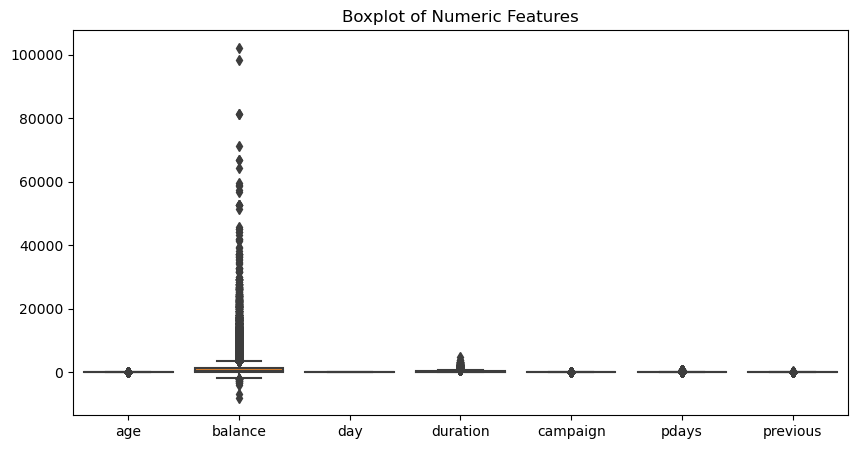

In [6]:
# Outlier check with boxplot before handling
numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, 5))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=0)
plt.title('Boxplot of Numeric Features')
plt.show()

In [7]:
# Function to replace outliers using IQR
def replace_outlier_with_iqr(column):
    Q1 = column.quantile(0.25)  
    Q3 = column.quantile(0.75)  
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
  
    outlier_mask = (column < lower_bound) | (column > upper_bound)
    column.loc[outlier_mask] = column.median()    
    return column

df[numeric_cols] = df[numeric_cols].apply(replace_outlier_with_iqr, axis=0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
# Data transformation with label encoder
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [9]:
# Data augmentation with ADASYN
X = df.drop(columns=['y'])
y = df['y']

def optimize_adasyn(X, y, max_iter=10):
    """
    Finding the optimal number of neighbors for ADASYN with up to 10 iterations.  

    Args:  
    - X (DataFrame): Dataset features.  
    - y (Series): Target labels.  
    - max_iter (int): Maximum number of iterations to test different numbers of neighbors.  

    Returns:  
    - X_resampled, y_resampled (DataFrame, Series): Augmented dataset.
    """
    best_X, best_y = None, None
    best_balance = 0
    best_neighbors = None

    for k in range(1, max_iter + 1):
        adasyn = ADASYN(n_neighbors=k, random_state=42)
        X_res, y_res = adasyn.fit_resample(X, y)
        
        class_counts = Counter(y_res)
        min_class_count = min(class_counts.values())  
        max_class_count = max(class_counts.values())
        balance_score = min_class_count / max_class_count

        print(f"Iterasi {k}: Neighbors={k}, Balance Score={balance_score:.3f}")

        if balance_score > best_balance:
            best_X, best_y = X_res, y_res
            best_balance = balance_score
            best_neighbors = k

    print(f"\nOptimal neighbors: {best_neighbors} with Balance Score={best_balance:.3f}")
    return best_X, best_y

X_resampled, y_resampled = optimize_adasyn(X, y)
print("Class distribution after ADASYN:", Counter(y_resampled))

Iterasi 1: Neighbors=1, Balance Score=0.997
Iterasi 2: Neighbors=2, Balance Score=0.995
Iterasi 3: Neighbors=3, Balance Score=0.973
Iterasi 4: Neighbors=4, Balance Score=0.974
Iterasi 5: Neighbors=5, Balance Score=0.993
Iterasi 6: Neighbors=6, Balance Score=0.992
Iterasi 7: Neighbors=7, Balance Score=0.995
Iterasi 8: Neighbors=8, Balance Score=0.999
Iterasi 9: Neighbors=9, Balance Score=0.959
Iterasi 10: Neighbors=10, Balance Score=0.986

Optimal neighbors: 8 with Balance Score=0.999
Class distribution after ADASYN: Counter({1: 39949, 0: 39922})


In [10]:
# Data scalling with Robust Scaler
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X_resampled) 
X_scaled_df = pd.DataFrame(X_scaled, columns=X_resampled.columns)

print("Data after scaling with RobustScaler:")
X_scaled_df.head()

Data after scaling with RobustScaler:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1.333333,0.000000,0.0,1.0,0.0,1.959538,1.0,0.0,2.0,-0.769231,0.4,0.479290,-1.0,0.0,0.0,0.0
1,0.400000,0.833333,1.0,0.0,0.0,-0.484393,1.0,0.0,2.0,-0.769231,0.4,-0.171598,-1.0,0.0,0.0,0.0
2,-0.333333,-0.333333,0.0,0.0,0.0,-0.515607,1.0,1.0,2.0,-0.769231,0.4,-0.615385,-1.0,0.0,0.0,0.0
3,0.600000,-0.500000,0.0,2.0,0.0,1.223121,1.0,0.0,2.0,-0.769231,0.4,-0.520710,-1.0,0.0,0.0,0.0
4,-0.333333,1.166667,1.0,2.0,0.0,-0.516763,0.0,0.0,2.0,-0.769231,0.4,0.106509,-1.0,0.0,0.0,0.0


# Model Selection
Model selection is carried out by testing several ensemble models such as Random Forest, Gradient Boosting, LightGBM, AdaBoost, CatBoost, and XGBoost because they are more robust to different data conditions, handle non-linearity well, and improve predictive performance by combining multiple weak learners into a strong model.

In [11]:
X = X_scaled_df
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    print("="*50)
    print(f"Model: {name}")

    model.fit(X_train, y_train)
 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc if auc != 'N/A' else 'Not Available'}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Model: Random Forest
Accuracy: 0.9269
F1 Score: 0.9282
Precision: 0.9155
Recall: 0.9413
AUC-ROC: 0.9795917364516836

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7954
           1       0.92      0.94      0.93      8021

    accuracy                           0.93     15975
   macro avg       0.93      0.93      0.93     15975
weighted avg       0.93      0.93      0.93     15975

Model: Gradient Boosting
Accuracy: 0.8906
F1 Score: 0.8922
Precision: 0.8833
Recall: 0.9013
AUC-ROC: 0.9582537096094589

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7954
           1       0.88      0.90      0.89      8021

    accuracy                           0.89     15975
   macro avg       0.89      0.89      0.89     15975
weighted avg       0.89      0.89      0.89     15975

Model: LightGBM
[LightGBM] [Info] Number of positive: 31928, n

C:\Users\Renata\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8750
F1 Score: 0.8757
Precision: 0.8745
Recall: 0.8768
AUC-ROC: 0.9467790766236367

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7954
           1       0.87      0.88      0.88      8021

    accuracy                           0.87     15975
   macro avg       0.87      0.87      0.87     15975
weighted avg       0.87      0.87      0.87     15975

Model: CatBoost
Accuracy: 0.9225
F1 Score: 0.9234
Precision: 0.9162
Recall: 0.9308
AUC-ROC: 0.9775654753644076

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7954
           1       0.92      0.93      0.92      8021

    accuracy                           0.92     15975
   macro avg       0.92      0.92      0.92     15975
weighted avg       0.92      0.92      0.92     15975

Model: XGBoost


C:\Users\Renata\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9234
F1 Score: 0.9245
Precision: 0.9151
Recall: 0.9340
AUC-ROC: 0.9782982685913396

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7954
           1       0.92      0.93      0.92      8021

    accuracy                           0.92     15975
   macro avg       0.92      0.92      0.92     15975
weighted avg       0.92      0.92      0.92     15975



From the results, Random Forest, XGBoost, and CatBoost all demonstrated strong performance. However, considering the characteristics of the dataset, **CatBoost is the most suitable method** as it can effectively handle datasets with a higher number of categorical features.

# Feature Selection

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy') 
rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)
print("Selected Feature:", X.columns[rfecv.support_])

Optimal number of features: 15
Selected Feature: Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome'],
      dtype='object')


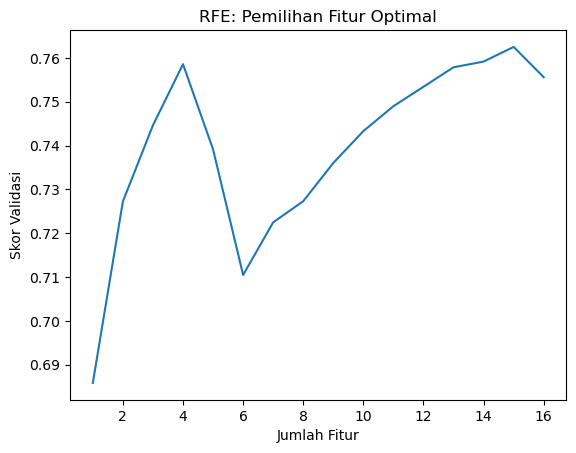

In [17]:
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Jumlah Fitur")
plt.ylabel("Skor Validasi")
plt.title("RFE: Pemilihan Fitur Optimal")
plt.show()

# Cross Validation and Hyperparameter Tuning

In [12]:
X = X_scaled_df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous', 'poutcome']]
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[I 2025-02-21 16:15:46,799] A new study created in memory with name: no-name-42069679-f74c-4f55-9e9a-01c45fde6bd6
C:\Users\Renata\AppData\Local\Temp\ipykernel_8036\428698901.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
[I 2025-02-21 16:17:02,886] Trial 0 finished with value: 0.9281958002547459 and parameters: {'iterations': 499, 'depth': 8, 'learning_rate': 0.11524400479228332, 'l2_leaf_reg': 6.9959690148817035}. Best is trial 0 with value: 0.9281958002547459.
C:\Users\Renata\AppData\Local\Temp\ipykernel_8036\428698901.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.

Best parameters for CatBoost: {'iterations': 443, 'depth': 10, 'learning_rate': 0.2037927477105982, 'l2_leaf_reg': 5.597760258068298}
Accuracy for CatBoost: 0.9356
F1 Score for CatBoost: 0.9362


100%|===================| 15971/15975 [70:24<00:01]        

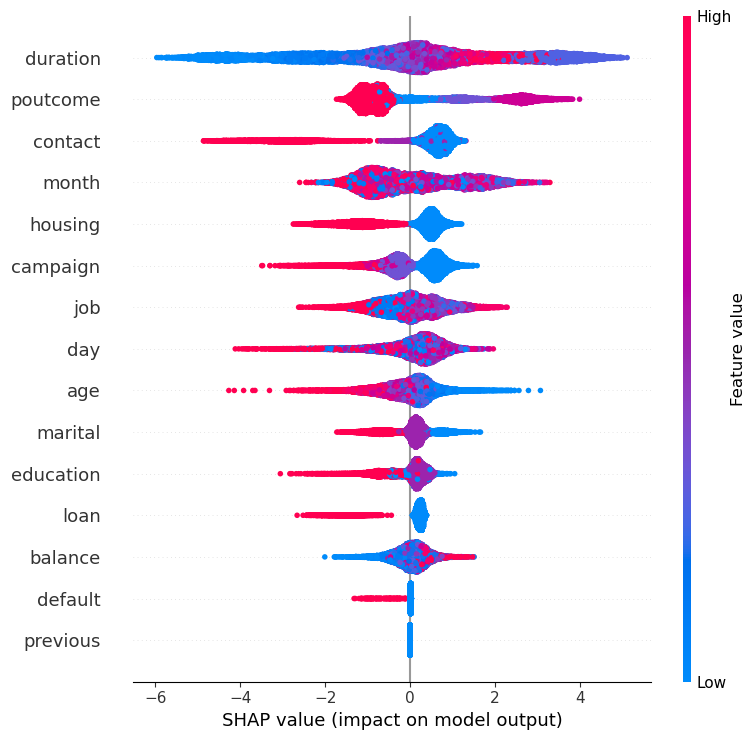

In [23]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 500),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    }
    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters for CatBoost:", best_params)

best_catboost = CatBoostClassifier(**best_params, random_state=42, verbose=0)
best_catboost.fit(X_train, y_train)

y_pred = best_catboost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy for CatBoost: {accuracy:.4f}")
print(f"F1 Score for CatBoost: {f1:.4f}")

explainer = shap.Explainer(best_catboost, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [13]:
final_model = CatBoostClassifier(iterations= 443, depth= 10, learning_rate= 0.2037927477105982, l2_leaf_reg= 5.597760258068298, random_state=42, verbose=0)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1] if hasattr(final_model, "predict_proba") else None

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc if auc != 'N/A' else 'Not Available'}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9356
F1 Score: 0.9362
Precision: 0.9274
Recall: 0.9452
AUC-ROC: 0.9828182222142111

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7985
           1       0.93      0.95      0.94      7990

    accuracy                           0.94     15975
   macro avg       0.94      0.94      0.94     15975
weighted avg       0.94      0.94      0.94     15975



In [24]:
joblib.dump(best_catboost, "best_model_CatBoost.pkl")
print("Best CatBoost model has been saved as best_model_CatBoost.pkl")

Best CatBoost model has been saved as best_model_CatBoost.pkl


The CatBoost model effectively handles categorical features and delivers a highly accurate and well-balanced classification for predicting bank subscription deposits. The AUC-ROC of 0.9828 further confirms that the model has strong predictive capability and can confidently differentiate between subscribed and non-subscribed customers. 